<a href="https://colab.research.google.com/github/MaruvadaSaketh/Road-lane-Detection/blob/main/Road_Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


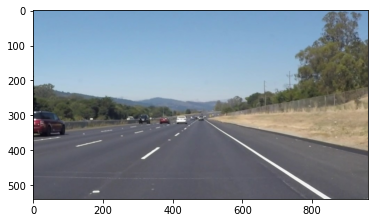

In [ ]:
image = mpimg.imread('WhiteRight.jpg')
print('This image is:',type(image),'with dimensions:',image.shape)
plt.imshow(image)

In [6]:
from os import defpath
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)          

  #or use BGR2GRAY if you read an image with cv2.imread()
  #return cv2.cvtcolor(img.cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernal_size):
    return cv2.GaussianBlur(img, (kernal_size, kernal_size),0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    if len(img.shape)>2:
       channel_count = img.shape[2]
       ignore_mask_color = (255,) * channel_count    

    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255,0,0], thickness=10):   

    imshape = img.shape

    left_lines = []

    right_lines = []

    left_lines_alinged = []
    right_lines_alinged = []
    left_m = []
    leftt_b = []
    right_m = []
    right_b = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            b = y1 - (m*x1)
            if m < 0: left_lines.append((m,b))
            if m > 0: right_lines.append((m,b)) 

    left_m = [line[0] for line in left_lines]
    left_m_avg = np.mean(left_m)
    left_m_std = np.std(left_m)

    for line in left_lines:
        if abs(line[0] - left_m_avg) < left_m_std:
           left_lines_alinged.append(line)

        if len(left_lines_alinged)  > 0:
           left_m = [line[0] for line in left_lines_alinged]
           ml = np.mean(left_m)   
           left_b = [line[1] for line in left_lines_alinged]
           bl = np.mean(left_b)

        else:
            ml = left_m_avg
            left_b = [line[1] for line in left_lines]
            bl = np.mean(left_b)

        right_m = [line[0] for line in right_lines]
        right_m_avg = np.mean(right_m)       
        right_m_std = np.std(right_m)

        for line in right_lines:
             if abs(line[0] - right_m_avg) < right_m_std:
              right_lines_alinged.append(line)

        if len(right_lines_alinged) > 0:
           right_m = [line[0] for line in right_lines_alinged]
           mr = np.mean(right_m)   
           right_b = [line[1] for line in right_lines_alinged]
           br = np.mean(right_b)

        else:
            mr = right_m_avg
            right_b = [line[1] for line in right_lines]
            br = np.mean(right_b)


            smooth_fact = 0.8
            if (abs(ml) < 1000):
                if(previous_lines[0] != 0):
                    ml = previous_lines[0]*smooth_fact + ml*(1-smooth_fact)
                    bl = previous_lines[1]*smooth_fact + bl*(1-smooth_fact)
            elif (previous_lines[0] != 0):
                  ml = previous_lines[0]
                  bl = previous_lines[1]
                  
            if (abs(mr) <1000):
                if (previous_lines[2] != 0):
                     mr = previous_lines[2]*smooth_fact + ml*(1-smooth_fact)
                     br = previous_lines[3]*smooth_fact + bl*(1-smooth_fact)
            elif (previous_lines[2] != 0):
                  mr = previous_lines[2]
                  br = previous_lines[3]       


            x1l = int((bl - imshape[0])/(-1*ml))     
            y1l = imshape[0]
            x2l = int((bl - 6*imshape[0]/10)/(-1*ml))
            y2l = int(6*imshape[0]/10)

            x1r = int((br - 6*imshape[0])/(-1*ml))     
            y1r = int(6*imshape[0]/10)
            x2r = int((bl - 6*imshape[0]/10)/(-1*ml))
            y2r = imshape[0]

            if (x2l < x1r):
                cv2.line(img, (x1l,y1l), (x2l,y2l), [0,255,0], thickness)
                cv2.line(img, (x1r,y1r), (x2r,y2r), [0,255,0], thickness)

            previous_lines[0] = ml
            previous_lines[1] = ml
            previous_lines[2] = ml
            previous_lines[3] = ml

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta,threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap) 
    line_img = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img          


def weighted_img(img, initial_img, a=0.8,b=0.6,y=0.):
    return cv2.addWeighted(initial_img, a,img,b,y)

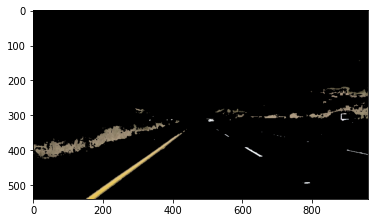

In [7]:
img = mpimg.imread('solidYellowCurve.jpg')
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask_white = cv2.inRange(img,(200,200,200),(255, 255, 255))
mask_yellow = cv2.inRange(hsv_img,(15,60,20),(25, 255, 255))
color_mask = cv2.bitwise_or(mask_white, mask_yellow)
masked_img = np.copy(img)
masked_img[color_mask == 0] = [0,0,0]
plt.imshow(masked_img)

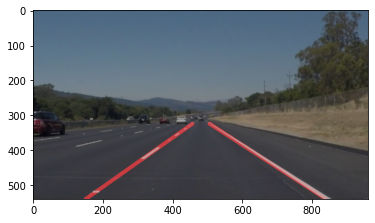

In [10]:
previous_lines = [0,0,0,0]
def lane_finding_pipeline(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_white = cv2.inRange(img,(200,200,200),(255, 255, 255))
    mask_yellow = cv2.inRange(hsv_img,(15,60,20),(25, 255, 255))
    color_mask = cv2.bitwise_or(mask_white, mask_yellow)
    masked_img = np.copy(img)
    masked_img[color_mask == 0] = [0,0,0]
    gray_img = grayscale(masked_img)
    kernel_size = 5
    blurred_gray_img = gaussian_blur(gray_img, kernel_size)
    low_threshold =50
    high_threshold = 150
    edges_from_img = canny(blurred_gray_img, low_threshold, high_threshold)
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(4*imshape[1]/9, 6*imshape[0]/10), (5*imshape[1]/9, 6*imshape[0]/10), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_from_img, vertices)
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 10
    max_line_gap = 5
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    overlay_img = weighted_img(line_img, img)

    return overlay_img
 

img = mpimg.imread('solidWhiteRight .jpg')
img_out = lane_finding_pipeline(img)
plt.imshow(img_out)
previous_lines = [0,0,0,0]

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2686976/45929032 bytes (5.9%)6266880/45929032 bytes (13.6%)9797632/45929032 bytes (21.3%)13467648/45929032 bytes (29.3%)16695296/45929032 bytes (36.4%)20275200/45929032 bytes (44.1%)23625728/45929032 bytes (51.4%)27238400/45929032 bytes (59.3%)30687232/45929032 bytes (66.8%)34267136/45929032 bytes (74.6%)37806080/45929032 bytes (82.3%)41353216/45929032 bytes (90.0%)

In [12]:
def process_image(image):
    result = lane_finding_pipeline(image)
    return result

In [31]:
white_output = 'white.mp4'
clip1 = VideoFileClip('solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio = False)
previous_lines = [0,0,0,0]

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 10.8 s, sys: 457 ms, total: 11.3 s
Wall time: 15.8 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [30]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio = False)
previous_lines = [0,0,0,0]

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:49<00:00, 13.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 38.1 s, sys: 1.42 s, total: 39.5 s
Wall time: 51.5 s


In [32]:
challenge_output = 'output.mp4'
clip3 = VideoFileClip('challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio = False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 98%|█████████▊| 39/40 [00:02<00:00, 15.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 2.38 s, sys: 125 ms, total: 2.51 s
Wall time: 3.44 s
